# TP OMA 1: First order methods for large scale regression

In this pratical exercise, we will train a linear regression model using first order methods as seen in the lectures.
In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute 𝑓(𝑥∗) using the normal equations ($𝑥^∗=(𝐴^𝑇 𝐴)^{−1}𝐴^𝑇 𝑏)$. 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

## Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown $\texttt{scikit-learn}$ machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [4]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0,random_state=1)
    return X,Y

In [5]:
n=1000
d=100

X,Y=generate_dataset(n,d)
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]


X= [[ 0.54388479 -0.06835299  0.35931907 ... -0.27375108 -0.9766115
  -0.81551607]
 [ 1.18372719  0.28982301  1.36999833 ... -0.25693591  0.68151479
  -1.34058922]
 [-0.26874365  0.27742379  0.04919037 ...  1.57390016 -1.07297349
  -1.5335487 ]
 ...
 [-0.45026897  0.6951639   0.33162952 ... -0.10780022  0.37213536
  -0.32577564]
 [ 0.81339708  0.64209946 -0.77231855 ...  2.26288921 -0.60404811
   0.33245633]
 [-0.53788036 -1.08675775  0.61632466 ...  1.08582807  0.72157706
   0.24852872]]
Y= [ 1.60321600e+03  8.39498315e+02  9.27681963e+01  9.78522695e+01
 -4.69659428e+02  5.21195246e+01 -4.07988533e+02  5.71185386e+02
 -9.83336039e+01 -1.93962606e+01 -1.92337969e+02 -3.37113729e+02
  4.99449910e+00  4.36407175e+02 -5.58362825e+01 -1.19412093e+03
  6.85286595e+01  5.76910601e+02 -7.85275709e+02  3.85637829e+02
 -4.74931606e+02  8.56395335e+02  2.99090694e+01 -1.25776722e+02
  3.80142122e+02  6.85888593e+02 -7.92342670e+02  6.67258202e+02
  4.85530453e+02  4.92359636e+01  2.75184616e+02

## Computing $f(x^*)$

In [6]:
def full_objective(Y, A, x):
    # Compute the least squares objective over the whole dataset
    return np.linalg.norm(Y - A.dot(x))**2

In [7]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)
print(x_star)


f(x*) =  86574.87053445776
[ 2.36828418 73.1981675  41.28689358  8.09886299 59.80978198 18.84186891
 83.09544152 47.92992182 90.2380817  34.63403299 37.8792958  10.50776633
  2.7102191  27.41995804 56.02837034  4.82294984 41.30032868 54.83024742
 88.42938474 90.20607104 91.1777999  69.47028837 75.98184771 38.29008643
 64.87169277 27.88953993 72.04696877 53.80447939 77.21877438  0.65269373
 83.42914431 62.01411808  3.01113892 89.72523974 31.75390586 72.26349562
 62.77489546 61.38841197 12.23618196  2.41104596 66.52618238 13.43018305
 92.71836858 84.53177611 22.06644152 45.42625828 70.32717708  7.53082932
 77.15098567 19.89627205 85.64038399 15.64188273 13.05618975 76.5648019
 40.13902351 93.69853195 11.22773645 24.17898778  9.2664705  59.69475321
 80.12259626  3.83051377 44.83438676 93.22676752 16.83968376  3.45233257
 42.66049945 79.52063948 43.98865476 96.63714857 32.96299531 24.68873148
 96.42599652  1.97043241 44.23336282 19.32732358  3.87132481 19.22475699
 37.93142994 71.10884028 

## Gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [8]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    
    grad = -1/n * A.T @ (Y - A @ x)
    return grad

Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [9]:
def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x - lr * grad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your GD on the regression problem you have generated earlier. You may try several values for the step size.

In [10]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.14

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives, gd_iterates = gradient_descent(
    Y, A, x_initial, nmax, lr)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/0999): objective = 243385215.44
GD(0001/0001/0999): objective = 176243689.28
GD(0002/0002/0999): objective = 128904390.61
GD(0003/0003/0999): objective = 95182640.31
GD(0004/0004/0999): objective = 70919371.63
GD(0005/0005/0999): objective = 53291686.23
GD(0006/0006/0999): objective = 40365399.03
GD(0007/0007/0999): objective = 30802529.29
GD(0008/0008/0999): objective = 23668623.22
GD(0009/0009/0999): objective = 18304824.07
GD(0010/0010/0999): objective = 14242229.45
GD(0011/0011/0999): objective = 11144069.39
GD(0012/0012/0999): objective = 8766328.41
GD(0013/0013/0999): objective = 6930692.08
GD(0014/0014/0999): objective = 5505796.35
GD(0015/0015/0999): objective = 4394116.94
GD(0016/0016/0999): objective = 3522722.39
GD(0017/0017/0999): objective = 2836696.38
GD(0018/0018/0999): objective = 2294419.78
GD(0019/0019/0999): objective = 1864159.27
GD(0020/0020/0999): objective = 1521581.48
GD(0021/0021/0999): objective = 1247928.12
GD(0022/0022/0999): objective = 1028666

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

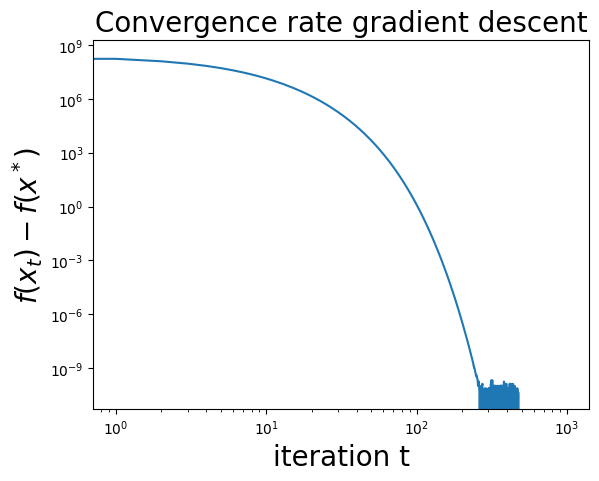

In [11]:
plt.title('Convergence rate gradient descent', fontsize = 20)
plt.loglog(gd_objectives - best_objective)
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.show()

## Gradient descent acceleration

We will try now to converge faster using the gradient acceleration. Recall the acceleration scheme that adds a momentum term in the update:
$$
x_{k+1}=x_k-\alpha_k\nabla f(x_k) +\beta_k(x_k-x_{k-1})
$$
with $\alpha_k=\frac{4}{(\sqrt{L}+\sqrt{\mu})^2}$ and $\beta_k=\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$
and $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$.

Based on the gradient descent function you have written above, write a new accelerated gradient function:

In [12]:
def accelerated_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    
    # Compute L and mu
    eigvals = np.linalg.eigvalsh(A.T @ A / len(Y))
    L = eigvals.max()
    mu = eigvals.min()
    
    # Compute alpha and beta
    alpha = 4 / (np.sqrt(L) + np.sqrt(mu))**2
    beta = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
    
    x = initial_x
    x_prev = initial_x
    
    for epoch in range(nmax):
        grad = -1 / len(Y) * A.T @ (Y - A @ x)
        
        # update x through the accelerated gradient update
        x_new = x - alpha * grad + beta * (x - x_prev)
        
        # store x and objective
        xs.append(x_new.copy())
        objective = np.linalg.norm(Y - A.dot(x_new))**2
        objectives.append(objective)
        
        print("AGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
        
        x_prev = x
        x = x_new
    
    return objectives, xs

Test now your accelerated GD on the regression problem you have generated earlier.

In [13]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives_acc, gd_iterates_acc = accelerated_gradient_descent(Y, A, x_initial, nmax)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))

AGD(0000/0000/0999): objective = 34860230.26
AGD(0001/0001/0999): objective = 21871623.41
AGD(0002/0002/0999): objective = 6765754.03
AGD(0003/0003/0999): objective = 1718495.68
AGD(0004/0004/0999): objective =  707076.59
AGD(0005/0005/0999): objective =  252667.60
AGD(0006/0006/0999): objective =  145480.51
AGD(0007/0007/0999): objective =  101555.28
AGD(0008/0008/0999): objective =   92515.34
AGD(0009/0009/0999): objective =   87975.66
AGD(0010/0010/0999): objective =   87077.31
AGD(0011/0011/0999): objective =   86743.70
AGD(0012/0012/0999): objective =   86614.81
AGD(0013/0013/0999): objective =   86590.56
AGD(0014/0014/0999): objective =   86579.23
AGD(0015/0015/0999): objective =   86576.29
AGD(0016/0016/0999): objective =   86575.26
AGD(0017/0017/0999): objective =   86575.01
AGD(0018/0018/0999): objective =   86574.91
AGD(0019/0019/0999): objective =   86574.88
AGD(0020/0020/0999): objective =   86574.87
AGD(0021/0021/0999): objective =   86574.87
AGD(0022/0022/0999): objective

Plot the convergence profile together with the previous plot to emphasize the acceleration, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

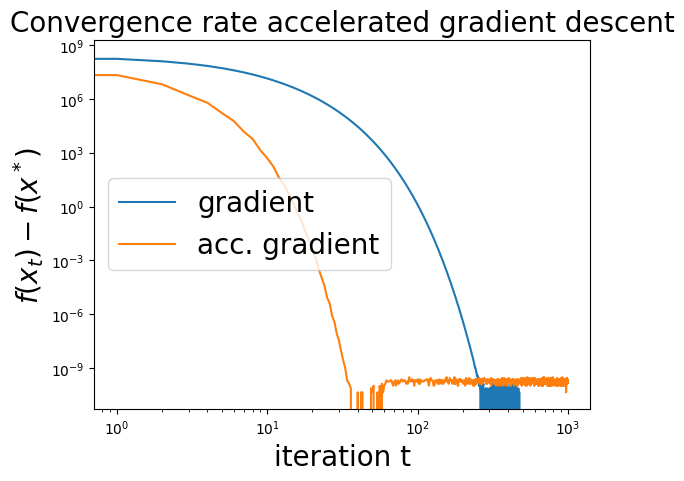

In [14]:
plt.figure(1)
plt.title('Convergence rate gradient descent', fontsize = 20)
plt.loglog(gd_objectives - best_objective,label = r'gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.title('Convergence rate accelerated gradient descent', fontsize = 20)
plt.loglog(gd_objectives_acc - best_objective,label = r'acc. gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.legend(fontsize = 20)
plt.show()

## Subgradient descent for the $L_1$ regularized regression problem (LASSO)

Consider now the LASSO problem where we have added a $L_1$ regularization term. The problem is no longer differentiable and we propose to use a subgradient technique to solve it:

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2 + \lambda \|x\|_{1}$$

where $\lambda>0$ is an hyperparameter.



Write first a new routine for the objective function

In [38]:
def reg_objective(Y, A, x,lbda):
    # Compute the least squares objective over the whole dataset
    return np.linalg.norm(Y - A.dot(x))**2 + lbda*np.linalg.norm(x=x,ord=1)

Write a subgradient function that will return a subgradient of $f$.

In [39]:
def subgradient_LASSO(Y, A, x, lbda):
    """
    Compute a subgradient of the LASSO problem for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    :param lbda: a positive scalar
    
    :return: subgradient: numpy array of shape (d)
    """

    n = len(Y)
    grad_least_squares = -1.0/n * A.T @ (Y - A @ x)
    
    # Subgradient for L1 regularization
    subgrad_l1 = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] > 0:
            subgrad_l1[i] = 1
        elif x[i] < 0:
            subgrad_l1[i] = -1
        else:
            subgrad_l1[i] = 0  # Could be any value in [-1,1] if x[i] == 0
    
    return grad_least_squares + lbda * subgrad_l1

Using your subgradient function, propose an implementation of the subgradient descent with constant step size to solve the linear regression problem.

In [57]:
def subgradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr, lbda):
    """
    Subgradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda: a positive scalar
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    best_obj=reg_objective(Y,A,initial_x,lbda)
    
    for epoch in range(nmax):
        subgrad = subgradient_LASSO(Y, A, x, lbda)

        
        x = x - lr * subgrad
    
        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        if objective<best_obj:
            best_obj=objective           
        objectives.append(best_obj)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=best_obj))
    return objectives, xs

Test now your Sub-GD on the regression problem you have generated earlier. You may try several values for the step size.

In [58]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1
lbda=10

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
subgd_objectives, subgd_iterates = subgradient_descent(
    Y, A, x_initial, nmax, lr,lbda)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/0999): objective = 269096600.96
GD(0001/0001/0999): objective = 222469829.10
GD(0002/0002/0999): objective = 185266527.63
GD(0003/0003/0999): objective = 155404378.72
GD(0004/0004/0999): objective = 131286562.51
GD(0005/0005/0999): objective = 111741352.51
GD(0006/0006/0999): objective = 95800581.14
GD(0007/0007/0999): objective = 82669809.07
GD(0008/0008/0999): objective = 71829572.48
GD(0009/0009/0999): objective = 62888064.14
GD(0010/0010/0999): objective = 55420980.89
GD(0011/0011/0999): objective = 49141120.03
GD(0012/0012/0999): objective = 43877071.17
GD(0013/0013/0999): objective = 39402121.05
GD(0014/0014/0999): objective = 35559414.33
GD(0015/0015/0999): objective = 32333976.56
GD(0016/0016/0999): objective = 29586940.25
GD(0017/0017/0999): objective = 27173268.72
GD(0018/0018/0999): objective = 25035600.68
GD(0019/0019/0999): objective = 23279258.75
GD(0020/0020/0999): objective = 21740307.12
GD(0021/0021/0999): objective = 20391032.90
GD(0022/0022/0999): object

GD(0132/0132/0999): objective = 9304691.45
GD(0133/0133/0999): objective = 9304691.45
GD(0134/0134/0999): objective = 9304691.45
GD(0135/0135/0999): objective = 9304691.45
GD(0136/0136/0999): objective = 9304691.45
GD(0137/0137/0999): objective = 9304691.45
GD(0138/0138/0999): objective = 9304691.45
GD(0139/0139/0999): objective = 9304691.45
GD(0140/0140/0999): objective = 9304691.45
GD(0141/0141/0999): objective = 9304691.45
GD(0142/0142/0999): objective = 9304691.45
GD(0143/0143/0999): objective = 9304691.45
GD(0144/0144/0999): objective = 9304691.45
GD(0145/0145/0999): objective = 9287051.93
GD(0146/0146/0999): objective = 9287051.93
GD(0147/0147/0999): objective = 9287051.93
GD(0148/0148/0999): objective = 9287051.93
GD(0149/0149/0999): objective = 9287051.93
GD(0150/0150/0999): objective = 9287051.93
GD(0151/0151/0999): objective = 9287051.93
GD(0152/0152/0999): objective = 9287051.93
GD(0153/0153/0999): objective = 9287051.93
GD(0154/0154/0999): objective = 9287051.93
GD(0155/015

GD(0000/0000/0999): objective = 269096600.96
GD(0001/0001/0999): objective = 222469829.10
GD(0002/0002/0999): objective = 185266527.63
GD(0003/0003/0999): objective = 155404378.72
GD(0004/0004/0999): objective = 131286562.51
GD(0005/0005/0999): objective = 111741352.51
GD(0006/0006/0999): objective = 95800581.14
GD(0007/0007/0999): objective = 82669809.07
GD(0008/0008/0999): objective = 71829572.48
GD(0009/0009/0999): objective = 62888064.14
GD(0010/0010/0999): objective = 55420980.89
GD(0011/0011/0999): objective = 49141120.03
GD(0012/0012/0999): objective = 43877071.17
GD(0013/0013/0999): objective = 39402121.05
GD(0014/0014/0999): objective = 35559414.33
GD(0015/0015/0999): objective = 32333976.56
GD(0016/0016/0999): objective = 29586940.25
GD(0017/0017/0999): objective = 27173268.72
GD(0018/0018/0999): objective = 25035600.68
GD(0019/0019/0999): objective = 23279258.75
GD(0020/0020/0999): objective = 21740307.12
GD(0021/0021/0999): objective = 20391032.90
GD(0022/0022/0999): object

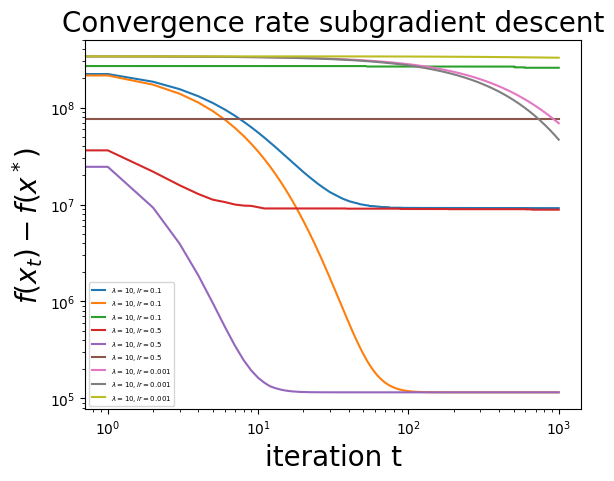

In [59]:
#compute and plot convergence profile for lr = 0.1, 0.5, 0,001 and lambda = 10, 1, 100
plt.figure(1)
plt.title('Convergence rate subgradient descent', fontsize = 20)
for lr in [0.1, 0.5, 0.001]:
    for lbda in [10, 1, 100]:
        subgd_objectives, subgd_iterates = subgradient_descent(Y, A, x_initial, nmax, lr,lbda)
        plt.loglog(subgd_objectives - best_objective,label = r'$\lambda = 10, lr = $' + str(lr))
        plt.xlabel('iteration t'  , fontsize = 20)
        plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 5)
plt.show()


Let us now plot the convergence profile, i.e. $f(x_t)$ with respect to the iteration $t$:

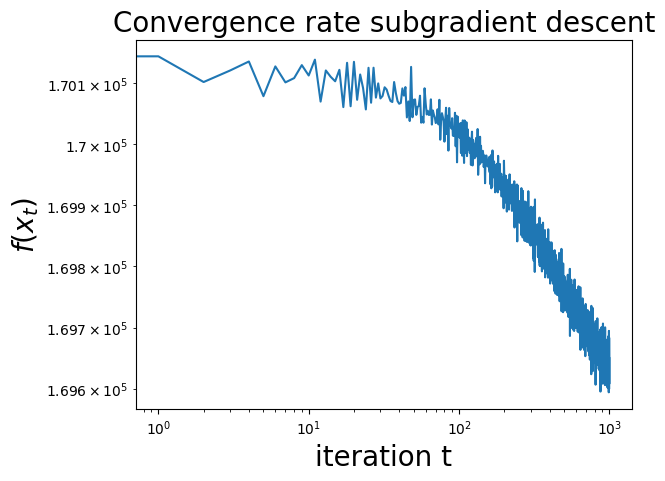

In [43]:
plt.title('Convergence rate subgradient descent', fontsize = 20)
plt.loglog(subgd_objectives)
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)
plt.show()

Propose a mean to check or visualize whether the solution of the LASSO is sparser (numerically speaking since zero coordinates may not be achieved) than the solution of the regression problem:

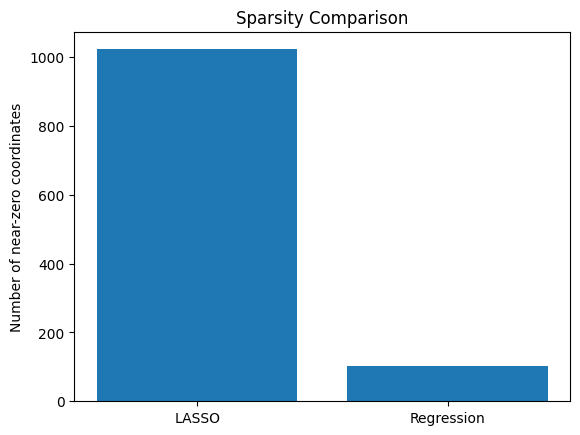

In [44]:
# TO DO
import numpy as np
import matplotlib.pyplot as plt

def compare_sparsity(x_lasso, x_reg, threshold=1e-3):
    lasso_near_zero = np.sum(np.abs(x_lasso) < threshold)
    reg_near_zero   = np.sum(np.abs(x_reg) < threshold)
    
    plt.bar(['LASSO','Regression'], [lasso_near_zero, reg_near_zero])
    plt.ylabel('Number of near-zero coordinates')
    plt.title('Sparsity Comparison')
    plt.show()

# Compare the sparsity of the LASSO and Ridge solutions
compare_sparsity(subgd_iterates, gd_iterates)


## Proximal gradient descent for the 𝐿1 regularized regression problem (LASSO)

We will now the same problem as before using the proximal gradient algorithm specifically designed for composite functions (one smooth term and one possibly non differentiable term). We recall proximal gradient update:
$$x_{k+1}=prox_{\alpha_k h}\left\{x_k-\alpha_k \nabla g(x_k)\right\}$$
where $g$ is the function such that $g(x)=\frac{1}{2n}\|Ax-b\|^2$ and $h$ such that $h(x)=\lambda\|x\|_1$.

Write a prox function that will return $prox_{\alpha \lambda\|.\|_1}$. Recall that the proximal operator is given by $prox_{\alpha \lambda\|.\|}$ is such that:
$$\left(prox_{\alpha \lambda\|.\|}\right)_i=\left(\begin{array}{ll} x_i-\alpha \lambda &\mbox{if } x_i>1\\ 0 & \mbox{if } x_i \in[-\alpha\lambda,\alpha\lambda]\\ x_i+\alpha\lambda & \mbox{if } x_i>1\end{array}\right. \qquad \forall i=1,\dots,d$$.

In [45]:
def prox_L1(v,alpha):
    """
    Proximal operator for the L1 norm (soft thresholding).
    """
    return np.sign(v) * np.maximum(np.abs(v) - alpha, 0)

Using your proximal operator, propose an implementation of the proximal gradient descent with constant step size to solve the linear regression problem:

In [53]:
def prox_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr,lbda):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda positive scalar
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = prox_L1(x - lr * grad, lr*lbda)
    
        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your proximal gradient method on the regression problem you have generated earlier and compare it with the subgradient method. You may try several values for the step size.

In [54]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1
lbda=10

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
proxgd_objectives, proxgd_iterates = prox_gradient_descent(Y, A, x_initial, nmax,lr,lbda)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))

GD(0000/0000/0999): objective = 278349199.50
GD(0001/0001/0999): objective = 229835834.23
GD(0002/0002/0999): objective = 191190149.21
GD(0003/0003/0999): objective = 160220959.46
GD(0004/0004/0999): objective = 135247057.58
GD(0005/0005/0999): objective = 114996535.43
GD(0006/0006/0999): objective = 98477180.67
GD(0007/0007/0999): objective = 84927549.33
GD(0008/0008/0999): objective = 73752373.49
GD(0009/0009/0999): objective = 64488708.47
GD(0010/0010/0999): objective = 56769411.97
GD(0011/0011/0999): objective = 50304397.44
GD(0012/0012/0999): objective = 44863346.25
GD(0013/0013/0999): objective = 40261723.19
GD(0014/0014/0999): objective = 36350381.22
GD(0015/0015/0999): objective = 33013306.93
GD(0016/0016/0999): objective = 30155167.13
GD(0017/0017/0999): objective = 27696015.08
GD(0018/0018/0999): objective = 25573991.78
GD(0019/0019/0999): objective = 23736371.51
GD(0020/0020/0999): objective = 22139675.14
GD(0021/0021/0999): objective = 20747888.83
GD(0022/0022/0999): object

Plot the convergence profile together with the previous plot (subgradient) and compare (i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$):

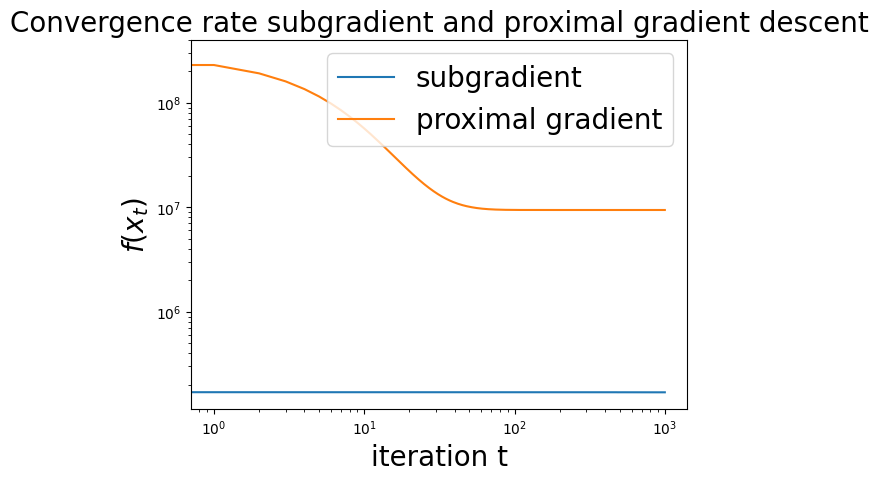

In [55]:
plt.figure(4)
plt.title('Convergence rate subgradient and proximal gradient descent', fontsize = 20)
plt.loglog(subgd_objectives,label = r'subgradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)

plt.loglog(proxgd_objectives,label = r'proximal gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()


GD(0000/0000/0999): objective = 76338664.60
GD(0001/0001/0999): objective = 24597818.01
GD(0002/0002/0999): objective = 9385948.06
GD(0003/0003/0999): objective = 4041517.43
GD(0004/0004/0999): objective = 1943230.61
GD(0005/0005/0999): objective = 1045339.62
GD(0006/0006/0999): objective =  635979.68
GD(0007/0007/0999): objective =  437121.11
GD(0008/0008/0999): objective =  335052.12
GD(0009/0009/0999): objective =  280140.89
GD(0010/0010/0999): objective =  249355.93
GD(0011/0011/0999): objective =  231462.42
GD(0012/0012/0999): objective =  219743.48
GD(0013/0013/0999): objective =  214030.34
GD(0014/0014/0999): objective =  210036.37
GD(0015/0015/0999): objective =  207341.10
GD(0016/0016/0999): objective =  205550.38
GD(0017/0017/0999): objective =  204362.30
GD(0018/0018/0999): objective =  203570.91
GD(0019/0019/0999): objective =  203040.68
GD(0020/0020/0999): objective =  202683.19
GD(0021/0021/0999): objective =  202440.67
GD(0022/0022/0999): objective =  202275.17
GD(0023/0

/home/kingmrock/.local/lib/python3.10/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


<Figure size 640x480 with 0 Axes>

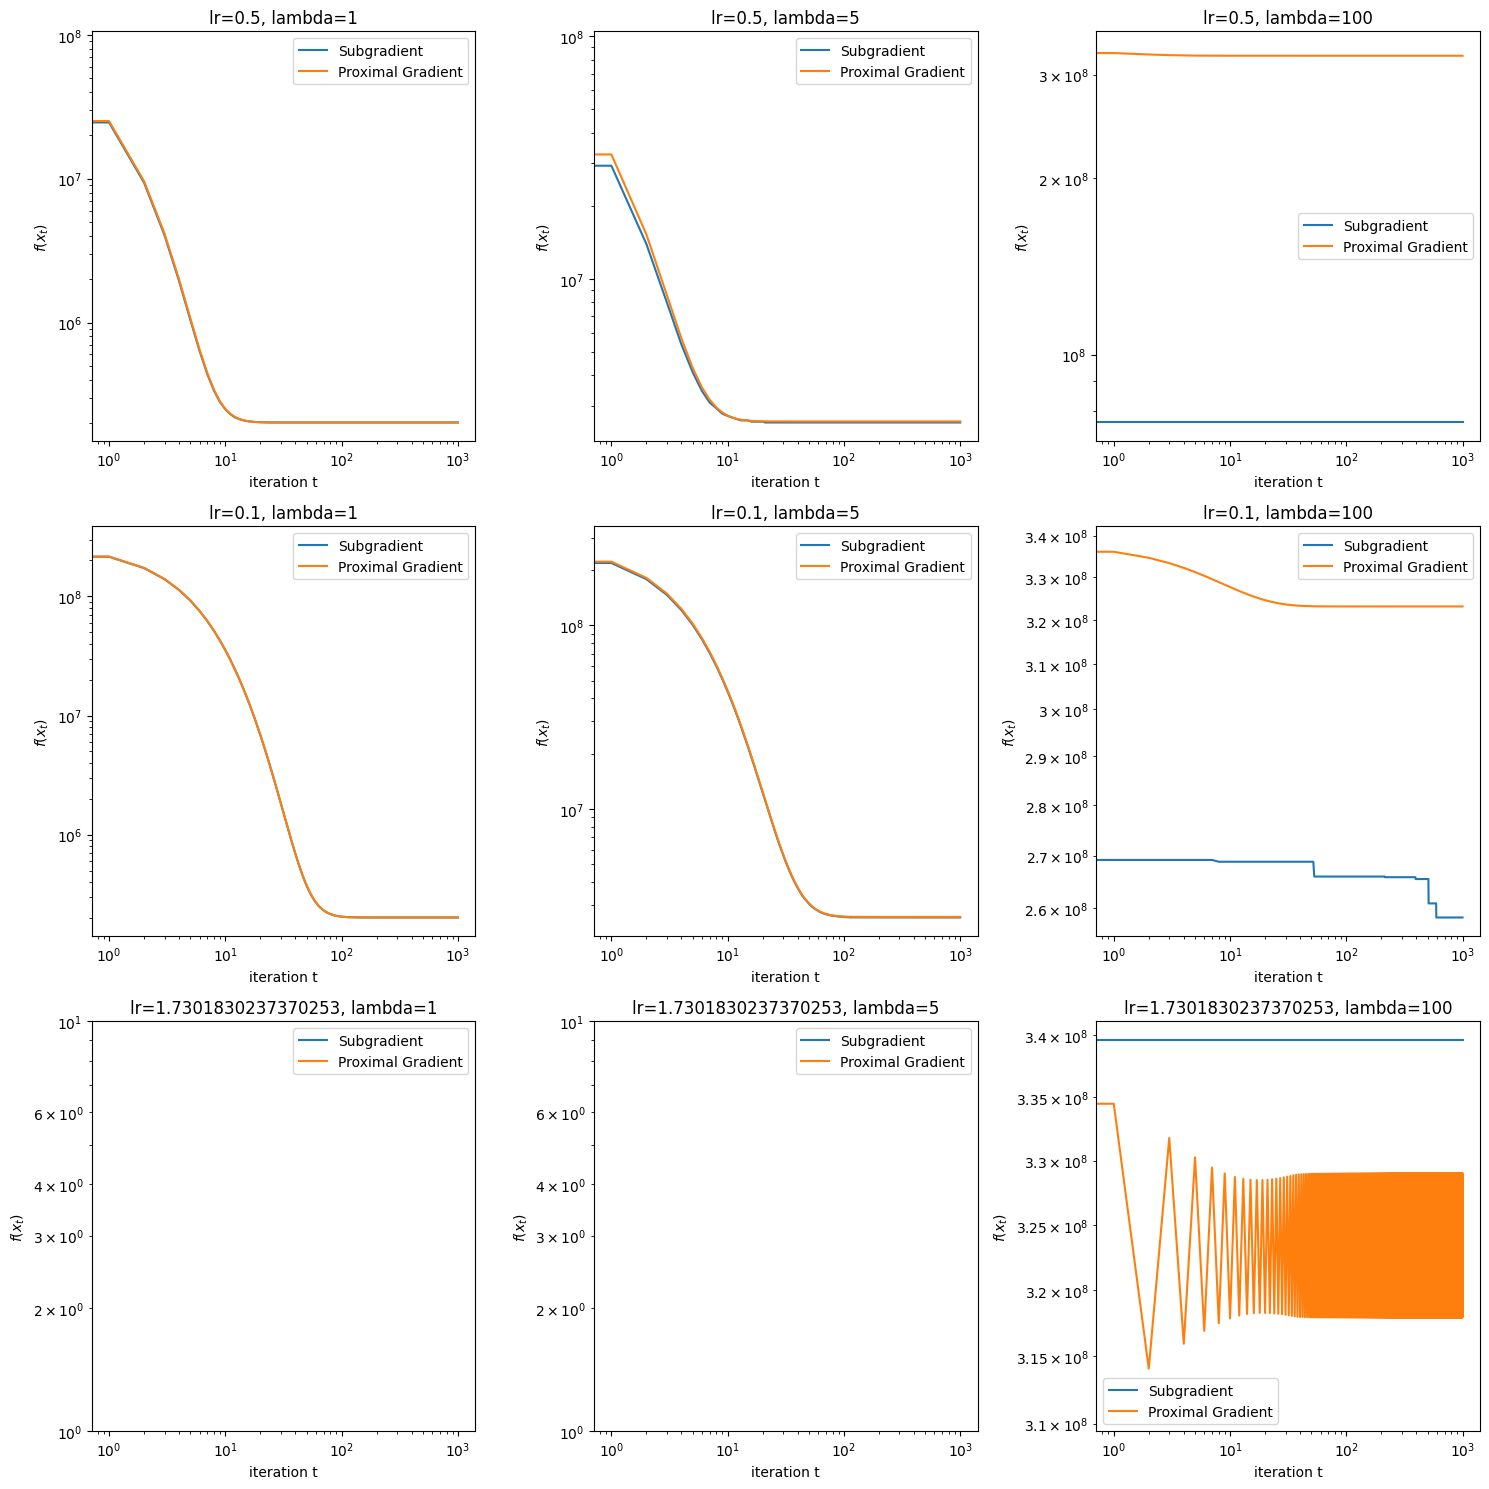

In [63]:
#compute subgradient vs proximal gradient for differenbt values of lambda and lr
plt.figure(5)
# Compute L and mu
eigvals = np.linalg.eigvalsh(A.T @ A / len(Y))
L = eigvals.max()
#create a 3*3 subfigures grid to plot subgradient vs proximal for each
lrs = [0.5, 0.1, L]
#last value is the largest eigenvalue of A^TA
lbdas = [1, 5, 100]



fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, lr in enumerate(lrs):
    for j, lbda in enumerate(lbdas):
        subgd_objectives, _ = subgradient_descent(Y, A, x_initial, nmax, lr, lbda)
        proxgd_objectives, _ = prox_gradient_descent(Y, A, x_initial, nmax, lr, lbda)
        
        ax = axs[i, j]
        ax.loglog(subgd_objectives, label='Subgradient')
        ax.loglog(proxgd_objectives, label='Proximal Gradient')
        ax.set_title(f'lr={lr}, lambda={lbda}')
        ax.set_xlabel('iteration t')
        ax.set_ylabel(r'$f(x_t)$')
        ax.legend()

plt.tight_layout()
plt.show()

Describe the experiments and comment the results from this notebook in your final report.